In [1]:
import tensorflow as tf
import xml.etree.ElementTree as ET
import numpy as np
from matplotlib import pyplot as plt
import os 
import shutil
import random
import cv2

2023-04-26 12:03:23.583120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 12:03:24.162770: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-26 12:03:24.162803: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-26 12:03:26.903806: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-04-26 12:03:31.373911: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/julysmartins/miniconda3/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-26 12:03:31.373982: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-26 12:03:31.374061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-04-26 12:03:31.463274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


False

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
images = tf.data.Dataset.list_files('data/columnU/*.jpg')

In [6]:
images.as_numpy_iterator().next()

b'data/columnU/postureIncorrect_344.jpg'

In [7]:
def load_image(x):
    bytes = tf.io.read_file(x)
    img = tf.image.decode_jpeg(bytes, channels=3)
    return img

In [8]:
images = images.map(load_image)

In [9]:
images.as_numpy_iterator().next()

array([[[ 12,  13,   8],
        [ 12,  13,   8],
        [ 11,  12,   7],
        ...,
        [ 29,  22,  16],
        [ 27,  18,  13],
        [ 24,  15,  10]],

       [[ 11,  12,   7],
        [ 12,  13,   8],
        [ 11,  12,   7],
        ...,
        [ 27,  20,  14],
        [ 27,  18,  13],
        [ 25,  16,  11]],

       [[ 12,  13,   8],
        [ 13,  14,   9],
        [ 13,  14,   9],
        ...,
        [ 28,  19,  14],
        [ 28,  17,  13],
        [ 28,  17,  13]],

       ...,

       [[ 38,  35,  44],
        [ 41,  38,  47],
        [ 41,  40,  48],
        ...,
        [110, 117, 109],
        [109, 116, 108],
        [108, 115, 107]],

       [[ 37,  34,  43],
        [ 40,  37,  46],
        [ 40,  39,  45],
        ...,
        [109, 116, 108],
        [109, 116, 108],
        [109, 116, 108]],

       [[ 38,  35,  44],
        [ 41,  38,  47],
        [ 39,  38,  44],
        ...,
        [109, 116, 108],
        [110, 117, 109],
        [111, 118, 110]]

In [10]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [11]:
image_generator = images.batch(4).as_numpy_iterator()

In [12]:
plot_images = image_generator.next()

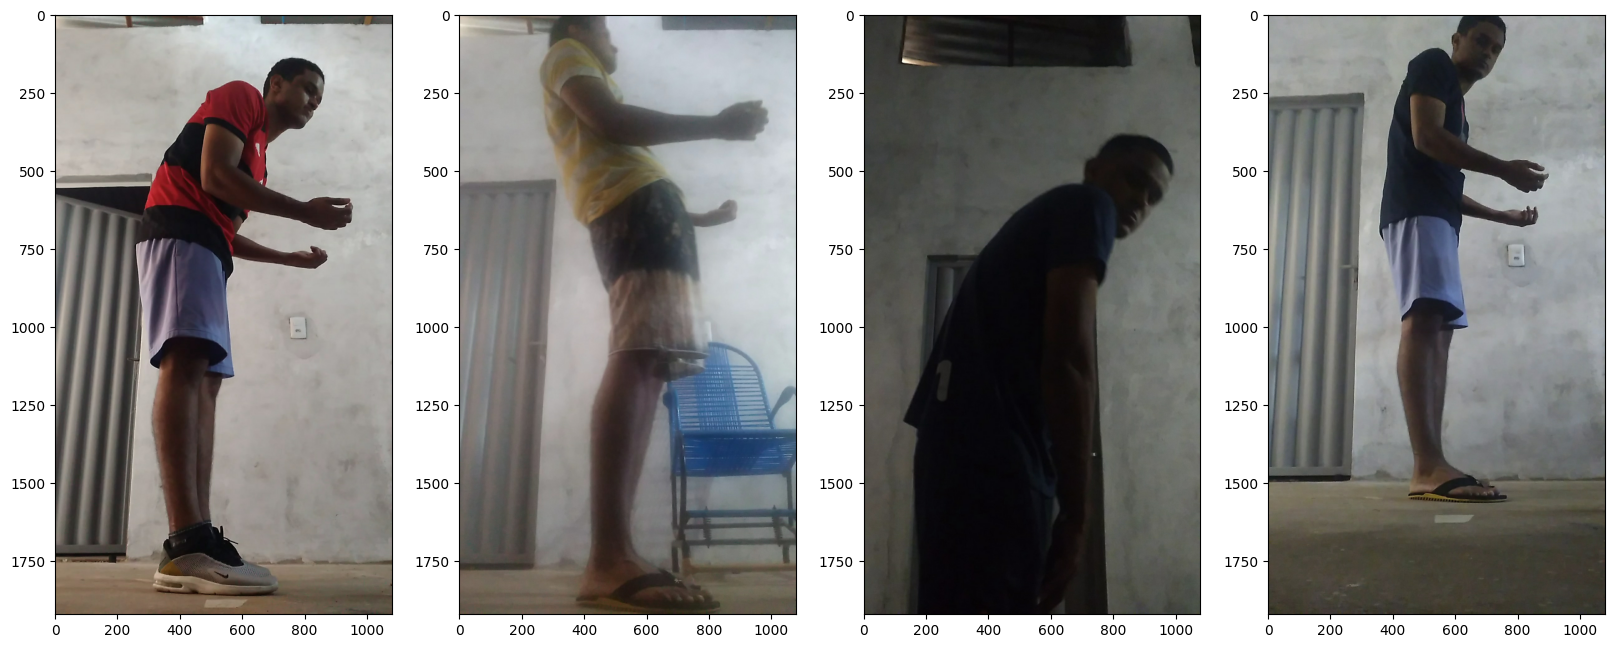

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(20, 20))
for i, ax in enumerate(axes):
    ax.imshow(plot_images[i])
plt.show()

splits images

In [14]:
source_dir = 'data/columnU'

target_dir = 'data/columnU_split'

train_percentage = 0.7
val_percentage = 0.2
test_percentage = 0.1

os.makedirs(os.path.join(target_dir, 'train/images'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'val/images'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'test/images'), exist_ok=True)

for filename in os.listdir(source_dir):
    if filename.endswith('.jpg'):
        source_path = os.path.join(source_dir, filename)
        rand = random.random()
        if rand < train_percentage:
            #reduce image size to 512x512
            img = cv2.imread(source_path)
            img = cv2.resize(img, (224, 224))
            cv2.imwrite(os.path.join(target_dir, 'train/images', filename), img)

            # shutil.copy(source_path, os.path.join(target_dir, 'train/images', filename))
            
        elif rand < train_percentage + val_percentage:

            img = cv2.imread(source_path)
            img = cv2.resize(img, (224, 224))
            cv2.imwrite(os.path.join(target_dir, 'val/images', filename), img)
            shutil.copy(source_path, os.path.join(target_dir, 'val/images', filename))
        else:
            #  shutil.copy(source_path, os.path.join(target_dir, 'test/images', filename))
             img = cv2.imread(source_path)
             img = cv2.resize(img, (512, 512))
             cv2.imwrite(os.path.join(target_dir, 'test/images', filename), img)
            

In [15]:
import xml.etree.ElementTree as ET

In [16]:
scale_x = 224 / 1920
scale_y = 224 / 1080
for folder in ['train', 'val', 'test']:
    for file in os.listdir(os.path.join('data/columnU_split/', folder, 'images')):    
        img_path = os.path.join('data/columnU_split/', folder, 'images', file)
        img  = cv2.imread(img_path)
        filename = file.split('.')[0]+'.xml'
        existing_path = os.path.join('data/', 'labels', filename)
        if os.path.exists(existing_path):
           xml_path = os.path.join('data/', 'labels', filename)
           tree = ET.parse(xml_path)
           root = tree.getroot()
           
           for obj in root.iter('object'):
               bbox = obj.find('bndbox')
               sizeBbox = obj.find('size')

               xmin = str(int(int(bbox.find('xmin').text) * scale_x))
               ymin = str(int(int(bbox.find('ymin').text) * scale_y))
               xmax = str(int(int(bbox.find('xmax').text) * scale_x))
               ymax = str(int(int(bbox.find('ymax').text) *  scale_y))

               bbox.find('xmin').text = xmin
               bbox.find('ymin').text = ymin
               bbox.find('xmax').text = xmax
               bbox.find('ymax').text = ymax

               
               
        tree.write(os.path.join('data/columnU_split/', folder, 'labels', filename))

In [17]:
import albumentations as alb

In [18]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [19]:
img = cv2.imread(os.path.join('data/columnU_split/train/images', 'postureIncorrect_0.jpg'))

In [20]:
with open(os.path.join('data/columnU_split/train/labels', 'postureIncorrect_0.xml')) as f:
    tree = ET.parse(f)
    root = tree.getroot()
    bboxes = []
    labels = []
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bboxes.append([xmin, ymin, xmax, ymax])
        labels.append(obj.find('name').text)
bboxes

[[37, 36, 99, 164]]

In [21]:
coords = [0,0,0,0]
coords[0] = bboxes[0][0]
coords[1] = bboxes[0][1]
coords[2] = bboxes[0][2]
coords[3] = bboxes[0][3]

coords


[37, 36, 99, 164]

In [22]:
coords = list(np.divide(coords,[img.shape[1],img.shape[0],img.shape[1],img.shape[0]]))

coords

[0.16517857142857142,
 0.16071428571428573,
 0.4419642857142857,
 0.7321428571428571]

In [23]:
coords


[0.16517857142857142,
 0.16071428571428573,
 0.4419642857142857,
 0.7321428571428571]

In [24]:
import cv2
import xml.etree.ElementTree as ET
import os

In [25]:
img_folder = 'data/columnU_split/test/images'
ann_folder = 'data/columnU_split/test/labels'

for filename in os.listdir(img_folder):
    if filename.endswith('.jpg'):
        img = cv2.imread(os.path.join(img_folder, filename))
        with open(os.path.join(ann_folder, filename.split('.')[0]+'.xml')) as f:
            tree = ET.parse(f)
            root = tree.getroot()
            for obj in root.findall('object'):
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                print(xmin, ymin, xmax, ymax)
                cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.imwrite(os.path.join('data/columnU_split/test/annotated', filename), img)
       

39 38 93 153
5 117 63 322
19 101 57 317
13 118 52 334
47 21 80 134
39 24 59 142
42 15 75 128
40 13 74 127
48 13 68 130
16 56 67 260
17 52 63 260
38 32 94 157
38 39 80 154
38 39 78 153
28 38 79 153
41 25 84 117
46 11 66 123
32 64 75 177
9 6 34 128
36 43 67 161
35 22 93 130
22 29 70 139
17 34 83 136
36 52 101 140
31 53 96 134
26 62 96 141
35 62 100 147
36 64 104 155
26 41 73 171
25 39 69 172
22 44 72 171
23 39 69 171
21 28 93 152
18 28 91 155
19 18 84 157
17 16 85 154
25 3 86 137
12 0 92 119
18 29 83 149
23 30 89 150
5 33 72 159
16 25 78 152
28 64 88 132
38 26 74 142
16 28 80 152
22 16 74 155
25 40 76 176
26 16 78 150
20 65 93 165
35 32 77 165
28 40 80 172
27 40 79 168
32 35 77 174
17 59 69 183
25 14 86 136
24 77 76 195
19 0 80 120
11 54 71 178
15 53 71 174
7 68 73 190
26 30 72 153
24 37 76 150
34 36 84 162
22 26 78 160
26 24 80 162
6 102 80 312
0 146 93 314
13 92 75 313
21 102 47 343
49 105 113 316
42 112 115 323
23 40 68 172
29 34 79 142
28 24 76 146
34 30 85 139
63 70 122 271
40 21 70

In [26]:

import tensorflow as tf
import numpy as np
import os
import cv2
import xml.etree.ElementTree as ET
import random
import albumentations as alb

train_img_folder = 'data/columnU_split/train/images'
train_ann_folder = 'data/columnU_split/train/labels'
val_img_folder = 'data/columnU_split/val/images'
val_ann_folder = 'data/columnU_split/val/labels'
test_img_folder = 'data/columnU_split/test/images'
test_ann_folder = 'data/columnU_split/test/labels'

#Convert images to a tensor format that can be used for training using a library such as TensorFlow images have width = 224 and height = 224
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0
    return image

#Convert bounding boxes to a tensor format that can be used for training using a library such as TensorFlow
def preprocess_bbox(bbox):
   
    xmin = bbox[0][0]
    ymin = bbox[0][1]
    xmax = bbox[0][2]
    ymax = bbox[0][3]
    return tf.convert_to_tensor([xmin, ymin, xmax, ymax])

#Convert class labels to a tensor format that can be used for training using a library such as TensorFlow
def preprocess_class(class_label):
    return tf.convert_to_tensor(class_label)

#Create a function that reads the image and annotation file and returns the image, bounding box, and class label

def read_image_and_annotation(image_folder, annotation_folder):
    image = tf.io.read_file(image_folder)
    image = preprocess_image(image)
    annotation_file = tf.io.read_file(annotation_folder)
    annotation_file = ET.fromstring(annotation_file.numpy())
    bbox = []
    class_label = []
    for obj in annotation_file.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append([xmin, ymin, xmax, ymax])
        
        class_label.append(obj.find('name').text)
    bbox = preprocess_bbox(bbox)
    class_label = preprocess_class(class_label)
    return image, bbox, class_label

#make for loop to read all images and annotations in the folder

def formats_data(img_folder, train_ann_folder):
    train_images_results = []
    train_bboxes_results = []
    train_class_labels_results = []
    for filename in os.listdir(img_folder):
     if filename.endswith('.jpg'):
         image, bbox, class_label = read_image_and_annotation(os.path.join(img_folder, filename),
                                                             os.path.join(train_ann_folder, filename.split('.')[0]+'.xml'))
         train_images_results.append(image)
         train_bboxes_results.append(bbox)
         train_class_labels_results.append(class_label)
    return train_images_results, train_bboxes_results, train_class_labels_results


train_images = []
train_bboxes = []
train_class_labels = []

train_images, train_bboxes, train_class_labels = formats_data(train_img_folder, train_ann_folder)
 
 



val_images = []
val_bboxes = []
val_class_labels = []

val_images, val_bboxes, val_class_labels = formats_data(val_img_folder, val_ann_folder)

test_images = []
test_bboxes = []
test_class_labels = []

test_images, test_bboxes, test_class_labels = formats_data(test_img_folder, test_ann_folder)







In [27]:
from tensorflow.keras.applications import EfficientNetB0

In [46]:
import tensorflow.keras.applications.resnet50 as resnet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, BatchNormalization
from sklearn.preprocessing import LabelEncoder 
from sklearn.utils import column_or_1d

In [54]:
model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# model.summary()

x = model.output

x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)

x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)

x = Dropout(0.5)(x)

x = Dense(64, activation='relu')(x)

x = Dropout(0.5)(x)

x = Dense(32, activation='relu')(x)

x = Dropout(0.5)(x)

x = Dense(16, activation='relu')(x)

x = Dropout(0.5)(x)

x = Dense(8, activation='relu')(x)

x = Dropout(0.5)(x)

x = Dense(4, activation='relu')(x)

x = Dropout(0.5)(x)

x = Dense(2, activation='relu')(x)

x = Dropout(0.5)(x)

x = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(model.input, x)

# model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, min_delta=0.0001)

train_images_new = np.array(train_images)

train_class_labels_new = np.array(train_class_labels)

# # train_class_labels_converted_in_float = train_class_labels_new.astype(np.float)

train_class_image_converted_in_float = train_images_new.astype(np.float)



# train_images_new = train_images_new.reshape(100, 224, 224, 3)
# train_class_labels_new = train_class_labels_new.reshape(100, 1)



le = LabelEncoder()

train_class_labels_new = le.fit_transform(train_class_labels_new)

train_class_labels_new = np.array(train_class_labels_new)

#resize train_class_labels_new to equal train_images_new with shape (684, 224, 224, 3)

train_class_labels_new = column_or_1d(train_class_labels_new, warn=True)
train_class_labels_new = train_class_labels_new.reshape(-1, 1)

val_images = np.array(val_images)
val_class_labels = np.array(val_class_labels)


assert train_class_labels_new.shape[0] == train_images_new.shape[0], "The shape of train_class_labels_new is not equal to train_images_new"

#model.fit(train_images_new, train_class_labels_new, batch_size=32, epochs=100)


model.fit(train_images_new, train_class_labels_new, batch_size=32, epochs=100, validation_data=(val_images, val_class_labels), callbacks=[checkpoint, early, reduce_lr])

model.save('model.h5')


/tmp/ipykernel_10004/527354071.py:70: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_class_image_converted_in_float = train_images_new.astype(np.float)
/home/julysmartins/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
22/22 [==============================] - 171s 7s/step - loss: 1.8591 - accuracy: 0.9211
Epoch 2/100
22/22 [==============================] - 160s 7s/step - loss: 1.2088 - accuracy: 0.9708
Epoch 3/100
22/22 [==============================] - 156s 7s/step - loss: 1.0702 - accuracy: 0.9839
Epoch 4/100
22/22 [==============================] - 148s 7s/step - loss: 0.6688 - accuracy: 0.9971
Epoch 5/100
22/22 [==============================] - 149s 7s/step - loss: 1.0639 - accuracy: 0.9868
Epoch 6/100
22/22 [==============================] - 148s 7s/step - loss: 1.6958 - accuracy: 0.9912
Epoch 7/100
22/22 [==============================] - 148s 7s/step - loss: 0.7996 - accuracy: 0.9795
Epoch 8/100
22/22 [==============================] - 147s 7s/step - loss: 0.6364 - accuracy: 0.9912
Epoch 9/100
22/22 [==============================] - 143s 7s/step - loss: 0.6190 - accuracy: 0.9883
Epoch 10/100
22/22 [==============================] - 142s 6s/step - loss: 0.6179 - accuracy: 0.9883

KeyboardInterrupt: 